### PySpark

#### Load the Libraries

In [59]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType
from pyspark.sql.functions import col, to_date
from pyspark.sql.functions import datediff
from pyspark.sql.functions import sum
from pyspark.sql.functions import year, month
from pyspark.sql import functions as F

# Initialize Spark session
spark = SparkSession.builder.appName("Sales Analysis Project").getOrCreate()

#### Load Dataset

In [60]:
df = spark.read.csv("/Users/hpourmand/Desktop/Retail/Superstore Sales Dataset.csv", header=True, inferSchema=True)

df.printSchema()
df.show(5)

root
 |-- Row ID: integer (nullable = true)
 |-- Order ID: string (nullable = true)
 |-- Order Date: string (nullable = true)
 |-- Ship Date: string (nullable = true)
 |-- Ship Mode: string (nullable = true)
 |-- Customer ID: string (nullable = true)
 |-- Customer Name: string (nullable = true)
 |-- Segment: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Postal Code: integer (nullable = true)
 |-- Region: string (nullable = true)
 |-- Product ID: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Sub-Category: string (nullable = true)
 |-- Product Name: string (nullable = true)
 |-- Sales: string (nullable = true)

+------+--------------+----------+----------+--------------+-----------+---------------+---------+-------------+---------------+----------+-----------+------+---------------+---------------+------------+--------------------+--------+
|Row ID|      Order ID|Order 

#### Handling missing values

In [62]:
# Fill the missing values
df = df.na.fill({"Postal Code": "00000"})

# Check the columns
null_columns = [col for col in df.columns if df.filter(F.col(col).isNull()).count() > 0]

df.select(null_columns).show()

++
||
++
||
||
||
||
||
||
||
||
||
||
||
||
||
||
||
||
||
||
||
||
++
only showing top 20 rows



#### Adjust the relevant columns to the appropriate data types

In [63]:
df = df.withColumn("Order Date", to_date(col("Order Date"), "yyyy-MM-dd")) \
       .withColumn("Ship Date", to_date(col("Ship Date"), "yyyy-MM-dd"))

df = df.withColumn("Postal Code", col("Postal Code").cast(StringType()))

df.printSchema()

root
 |-- Row ID: integer (nullable = true)
 |-- Order ID: string (nullable = true)
 |-- Order Date: date (nullable = true)
 |-- Ship Date: date (nullable = true)
 |-- Ship Mode: string (nullable = true)
 |-- Customer ID: string (nullable = true)
 |-- Customer Name: string (nullable = true)
 |-- Segment: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Postal Code: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Product ID: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Sub-Category: string (nullable = true)
 |-- Product Name: string (nullable = true)
 |-- Sales: string (nullable = true)



#### Ensure uniqueness of "Row ID" and "Order ID"

In [64]:
row_id_count = df.select("Row ID").distinct().count()
order_id_count = df.select("Order ID").distinct().count()

# Total rows
total_rows = df.count()

print(f"Total rows: {total_rows}")
print(f"Unique Row IDs: {row_id_count}")
print(f"Unique Order IDs: {order_id_count}")

Total rows: 9800
Unique Row IDs: 9800
Unique Order IDs: 4922


#### The distribution of shipping durations

In [65]:
#Summary Statistics
df.describe(["Sales"]).show()

# Shipping duration
df = df.withColumn("Shipping Duration", datediff(col("Ship Date"), col("Order Date")))

# Show basic statistics for Shipping Duration
df.select("Shipping Duration").describe().show()

# Analyze shipping mode usage
ship_mode_count = df.groupBy("Ship Mode").count().orderBy("count", ascending=False)
ship_mode_count.show()

+-------+-----------------+
|summary|            Sales|
+-------+-----------------+
|  count|             9800|
|   mean|235.2895627576727|
| stddev| 635.178384045279|
|    min|         10/Pack"|
|    max|           999.98|
+-------+-----------------+

+-------+-----------------+
|summary|Shipping Duration|
+-------+-----------------+
|  count|                0|
|   mean|             NULL|
| stddev|             NULL|
|    min|             NULL|
|    max|             NULL|
+-------+-----------------+

+--------------+-----+
|     Ship Mode|count|
+--------------+-----+
|Standard Class| 5859|
|  Second Class| 1902|
|   First Class| 1501|
|      Same Day|  538|
+--------------+-----+



#### Customer Segmentation Analysis

In [66]:
segment_sales = df.groupBy("Segment").agg(
    sum("Sales").alias("Total Sales")
).orderBy("Total Sales", ascending=False)

segment_sales.show()

+-----------+------------------+
|    Segment|       Total Sales|
+-----------+------------------+
|   Consumer|1137126.4019999914|
|  Corporate| 678952.2218000003|
|Home Office| 421054.5389000004|
+-----------+------------------+



#### Understand the distribution of orders and sales by location

In [23]:
# Group by Region and calculate total and average sales
region_sales = df.groupBy("Region").agg(
    sum("Sales").alias("Total Sales")
).orderBy("Total Sales", ascending=False)

region_sales.show()

# Group by Country and count order
country_orders = df.groupBy("Country").count().orderBy("count", ascending=False)
country_orders.show()

+-------+------------------+
| Region|       Total Sales|
+-------+------------------+
|   West| 698354.7745000002|
|   East| 663043.8579999986|
|Central|489321.39120000065|
|  South|386413.13900000043|
+-------+------------------+

+-------------+-----+
|      Country|count|
+-------------+-----+
|United States| 9800|
+-------------+-----+



#### Analyze sales over time

In [24]:
# Extract year and month from Order Date
df = df.withColumn("Order Year", year(col("Order Date"))) \
       .withColumn("Order Month", month(col("Order Date")))

# Total sales per year
sales_by_year = df.groupBy("Order Year").agg(sum("Sales").alias("Total Sales")).orderBy("Order Year")
sales_by_year.show()

# Total sales per month
sales_by_month = df.groupBy("Order Month").agg(sum("Sales").alias("Total Sales")).orderBy("Order Month")
sales_by_month.show()

+----------+------------------+
|Order Year|       Total Sales|
+----------+------------------+
|      NULL|2237133.1626999523|
+----------+------------------+

+-----------+------------------+
|Order Month|       Total Sales|
+-----------+------------------+
|       NULL|2237133.1626999523|
+-----------+------------------+



### Vizualization

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#### Convert to Pandas dataframe

In [26]:
segment_sales_pd = segment_sales.toPandas()
ship_mode_count_pd = ship_mode_count.toPandas()
sales_by_year_pd = sales_by_year.toPandas()

#### Sales by Customer Segment

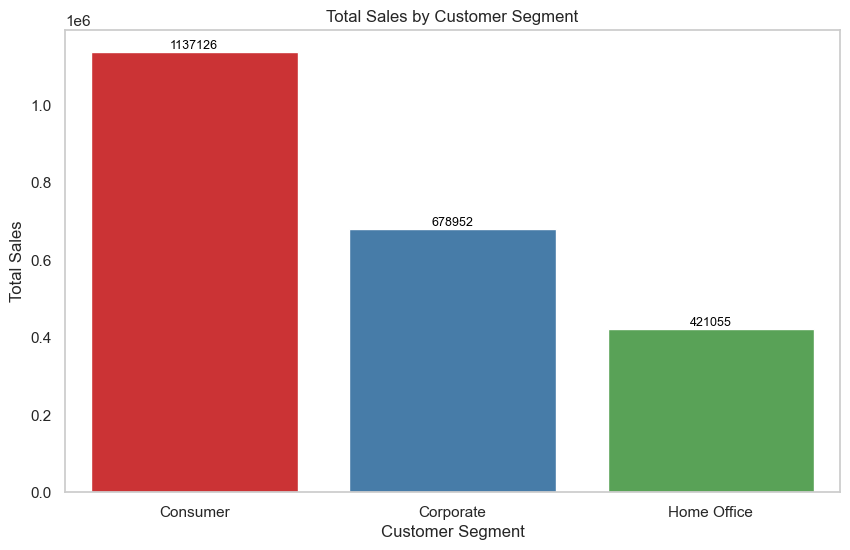

In [48]:
# Set color palette
color_palette = sns.color_palette('Set1')

# Sales by customer segment
plt.figure(figsize=(10, 6))
sns.barplot(data=segment_sales_pd, x="Segment", y="Total Sales", palette=color_palette)

# Adding annotations
for i, p in enumerate(plt.gca().patches):  
    height = p.get_height()  
    plt.text(p.get_x() + p.get_width() / 2, height + 1000, 
             f"{height:.0f}", 
             horizontalalignment='center', 
             verticalalignment='bottom', 
             fontsize=9, color='black')

plt.title("Total Sales by Customer Segment")
plt.xlabel("Customer Segment")
plt.ylabel("Total Sales")
plt.grid(False)
plt.show()

#### Shipping Mode Usage

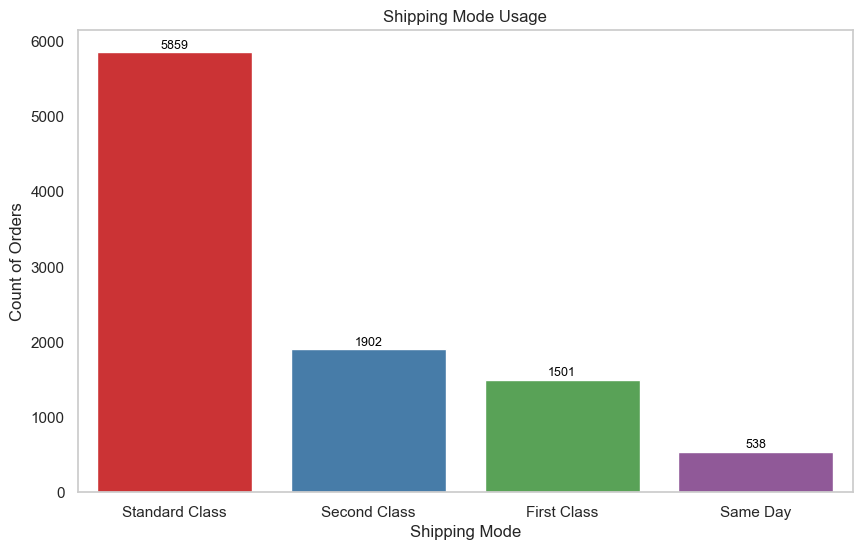

In [49]:
# Plot shipping mode count
plt.figure(figsize=(10, 6))
sns.barplot(data=ship_mode_count_pd, x="Ship Mode", y="count", palette=color_palette)

# Adding annotations
for i, p in enumerate(plt.gca().patches):  
    height = p.get_height()  
    plt.text(p.get_x() + p.get_width() / 2, height + 10,  
             f"{height:.0f}",  
             horizontalalignment='center', 
             verticalalignment='bottom', 
             fontsize=9, color='black')

plt.title("Shipping Mode Usage")
plt.xlabel("Shipping Mode")
plt.ylabel("Count of Orders")
plt.grid(False)
plt.show()


#### Region-Based Sales Distribution

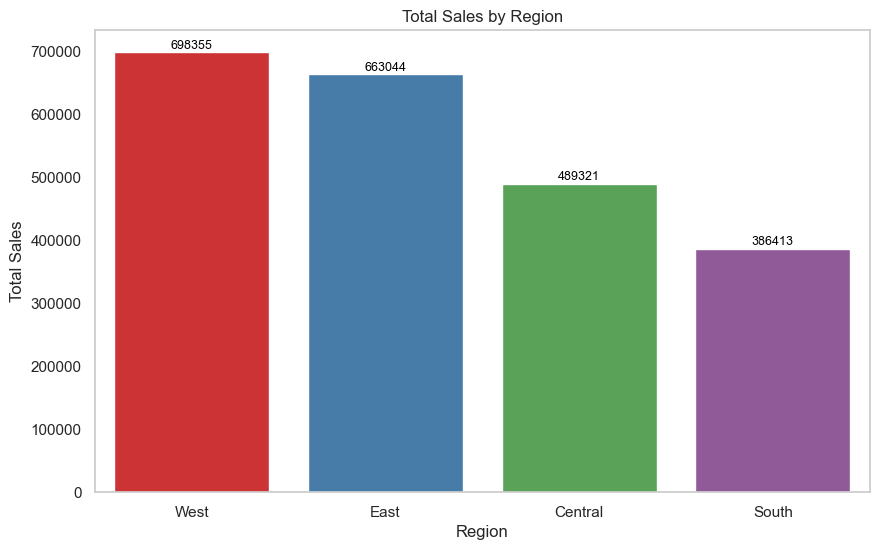

In [56]:
# Sales by region
plt.figure(figsize=(10, 6))
sns.barplot(data=region_sales_pd, x="Region", y="Total Sales", palette=color_palette)

# Adding annotations 
for i, p in enumerate(plt.gca().patches):  
    height = p.get_height() 
    plt.text(p.get_x() + p.get_width() / 2, height + 1000, 
             f"{height:.0f}",  
             horizontalalignment='center', 
             verticalalignment='bottom', 
             fontsize=9, color='black')

plt.title("Total Sales by Region")
plt.xlabel("Region")
plt.ylabel("Total Sales")
plt.grid(False)
plt.show()
